In [4]:
import pandas as pd
import json
from environs import Env
from graph_functions import (query_to_df, 
                            start_graph_session, start_graph_session_crashdown,
                            is_it_cancer, is_it_breast_cancer)
from IPython.display import Image


env = Env()
#session = start_graph_session(env) 
session = start_graph_session_crashdown(env) 

14196


In [7]:
genes_gwas_exp = pd.read_csv("query_results/bc_gwas_expressed_in_breastTissue.tsv", sep = '\t') # from notebook 2
genes_gwas_exp['about'].value_counts()


cancer_target    13
drug_target       6
Name: about, dtype: int64

In [8]:
# genes that are not known targets for cancer drugs
gene_list = list(set(genes_gwas_exp[genes_gwas_exp['about']!='cancer_target']['gene.name']))
len(gene_list)

93

### Plan: gene->protein; map to pathway - find all other proteins in the in the pathways; map them to genes; then those genes to drugs and diseases

In [70]:
# review how many pathways proteins of genes [without cancer-related drug targets] have
query = """
    MATCH (gene1:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein)-[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gene1.name in {}
    RETURN gene1.name, protein.uniprot_id, 
           collect (pathway.name) as Pathways, count (pathway.name) as N_pathways 
    ORDER BY N_pathways desc
    """.format(gene_list)

df1 = query_to_df(session, query)
df1
len(set(df1['gene1.name'])) # 51


    MATCH (gene1:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein)-[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gene1.name in ['ABO', 'TRIM46', 'STXBP4', 'PIDD', 'LGR6', 'PHLDA3', 'ELL', 'VPS33B', 'ADSSL1', 'MAGI3', 'SV2A', 'CBX8', 'TGFBR2', 'VGLL3', 'ARHGEF5', 'HSCB', 'DNAJC1', 'EBF1', 'CMSS1', 'ZMIZ1', 'KRTCAP2', 'TET2', 'MYEOV', 'OTUD7B', 'SF3B4', 'MKL1', 'RPL23AP53', 'GATAD2A', 'SETBP1', 'LMX1B', 'TCF7L2', 'ASTN2', 'LINC-PINT', 'FAM46A', 'BABAM1', 'MLLT10', 'CCDC88C', 'KANSL1', 'SCAMP2', 'USHBP1', 'RIN3', 'KCNN4', 'CDYL2', 'N4BP2L1', 'GIPR', 'ITPR1', 'HSPA4', 'FOXP1', 'ZNF184', 'RCCD1', 'CUX1', 'ADCY9', 'ATG10', 'LSP1', 'CDKN2B', 'NRIP1', 'FTO', 'ULK3', 'OR2A1-AS1', 'ZFPM2', 'NEK10', 'MTMR11', 'ANKLE1', 'MCM8', 'RNF115', 'MDM4', 'RANBP9', 'NREP', 'ADCY3', 'CREB5', 'PLA2G6', 'L3MBTL3', 'CDCA7L', 'SUB1', 'SSBP4', 'GRHL1', 'CASP8', 'ARRDC3', 'TTC28', 'TLR1', 'PRC1', 'PEX14', 'RAD51B', 'RP11-134G8.8', 'SLC25A22', 'FAM175A', 'FILIP1L', 'ATXN7', 'ATAD5'

51

In [10]:
# map gene-protein to to pathway - find all other proteins in the pathways; map them to genes;

query = """
    MATCH (gene1:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein1:Protein)-[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway)<-[PROTEIN_IN_PATHWAY]-(protein2:Protein)-[GENE_TO_PROTEIN]-(gene2:Gene)
    //WHERE gene1.name in ['ATG10', 'TGFBR2']
    WHERE gene1.name in {}
    RETURN gene1.name, protein1.uniprot_id, pathway.name, pathway.id,
    //collect(protein2.uniprot_id) as `all_pathway_proteins`, 
    //count(protein2.uniprot_id) as `N_proteins_in_pathway`,
    collect(gene2.name) as `all_genes_from_proteins`, 
    count(gene2.name) as `N_genes_from_proteins`
    ORDER BY pathway.name
    """.format(list(df1['gene1.name']))
df_genes_to_genes = query_to_df(session, query)
df_genes_to_genes


    MATCH (gene1:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein1:Protein)-[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway)<-[PROTEIN_IN_PATHWAY]-(protein2:Protein)-[GENE_TO_PROTEIN]-(gene2:Gene)
    //WHERE gene1.name in ['ATG10', 'TGFBR2']
    WHERE gene1.name in ['ITPR1', 'CASP8', 'ADCY3', 'ADCY9', 'ELL', 'MDM4', 'GATAD2A', 'TCF7L2', 'CBX8', 'MCM8', 'TLR1', 'TGFBR2', 'CDKN2B', 'PLA2G6', 'FAM175A', 'BABAM1', 'RANBP9', 'NRIP1', 'GIPR', 'RAD51B', 'OTUD7B', 'ARHGEF5', 'MKL1', 'SV2A', 'ATXN7', 'PEX14', 'VPS33B', 'PIDD', 'AMFR', 'CUX1', 'SF3B4', 'PRC1', 'HSCB', 'SLC25A22', 'HSPA4', 'GRHL1', 'CCDC88C', 'TRIM46', 'CUX1', 'ADSSL1', 'RIN3', 'RNF115', 'LGR6', 'KANSL1', 'ZNF184', 'KCNN4', 'ULK3', 'FTO', 'TET2', 'ATG10', 'EBF1', 'ZFPM2']
    RETURN gene1.name, protein1.uniprot_id, pathway.name, pathway.id,
    //collect(protein2.uniprot_id) as `all_pathway_proteins`, 
    //count(protein2.uniprot_id) as `N_proteins_in_pathway`,
    collect(gene2.name) as `all_genes_from_proteins`, 


,gene1.name,protein1.uniprot_id,pathway.name,pathway.id,all_genes_from_proteins,N_genes_from_proteins
0,ADCY3,O60266,ADORA2B mediated anti-inflammatory cytokines p...,R-HSA-9660821,"[GPR20, GPHA2, TAAR1, TAAR6, P2RY11, PTH2, TAA...",132
1,GIPR,P48546,ADORA2B mediated anti-inflammatory cytokines p...,R-HSA-9660821,"[GPR20, GPHA2, TAAR1, TAAR6, P2RY11, PTH2, TAA...",132
2,ADCY9,O60503,ADORA2B mediated anti-inflammatory cytokines p...,R-HSA-9660821,"[GPR20, GPHA2, TAAR1, TAAR6, P2RY11, PTH2, TAA...",132
3,MCM8,Q9UJA3,Activation of ATR in response to replication s...,R-HSA-176187,"[CDC6, RAD9A, ATRIP, MCM10, RAD9B, MCM6, ATR, ...",36
4,ADCY3,O60266,Activation of GABAB receptors,R-HSA-991365,"[KCNJ15, KCNJ9, ADCY4, KCNJ12, ADCY1, ADCY2, K...",42
...,...,...,...,...,...,...
622,SF3B4,Q15427,mRNA Splicing - Major Pathway,R-HSA-72163,"[CDC5L, RBM17, SNRNP40, PPWD1, MAGOHB, CLP1, G...",178
623,SF3B4,Q15427,mRNA Splicing - Minor Pathway,R-HSA-72165,"[RNPC3, SNRNP40, ZCRB1, PDCD7, DDX42, PRPF8, S...",51
624,MDM4,O15151,p53-Dependent G1 DNA Damage Response,R-HSA-69563,"[PSMD1, PSMB7, ZNF385A, PSMF1, PSMA8, RFWD2, C...",65
625,MDM4,O15151,p53-Dependent G1/S DNA damage checkpoint,R-HSA-69580,"[PSMD1, PSMB7, ZNF385A, PSMF1, PSMA8, RFWD2, C...",65


In [11]:
# collect all genes involved in pathways
gene2_list = list(set(df_genes_to_genes['all_genes_from_proteins'].explode()))
len(gene2_list)

10220

In [12]:
# map genes to drugs and diseases
query="""
match (gene:Gene)-[]-(drug:Drug)-[]-(d:Disease)
where gene.name in {}
return gene.name , drug.label, d.label
""".format(gene2_list)
df2= query_to_df(session, query)
df2


match (gene:Gene)-[]-(drug:Drug)-[]-(d:Disease)
where gene.name in ['CYP4A22', 'TRAPPC11', 'KCNA2', 'LSS', 'RXRB', 'MYO18A', 'MRPS22', 'SELE', 'PPIP5K2', 'POLR3A', 'CSNK2B', 'ABHD14B', 'A1CF', 'NCR3', 'ARID2', 'INTS8', 'ZNF468', 'MMAA', 'FAM105B', 'DCUN1D1', 'GNAT2', 'CNOT6', 'TFF1', 'NABP2', 'AP1M1', 'GDE1', 'SRSF6', 'RNF14', 'AQP4', 'GALNT1', 'MTERFD2', 'LYPLA2', 'OR10A4', 'WDR12', 'HYAL1', 'CTGF', 'BUD31', 'ERCC6', 'NTS', 'ZNF131', 'BGLAP', 'BCS1L', 'GABRB3', 'SLC5A2', 'PNLIP', 'DEFB4B', 'CASP4', 'EIF3M', 'DCLRE1A', 'SLC35B2', 'NEK2', 'APOA4', 'PSMC6', 'INTS3', 'CFHR5', 'ORC5', 'DDX49', 'PAFAH1B3', 'ZNF665', 'CEBPD', 'NCK1', 'RPL6', 'WASL', 'TAS1R2', 'UQCRH', 'CMC4', 'NMRAL1', 'CNR2', 'RNF40', 'ZNF266', 'CTLA4', 'CCL3L1', 'RHOH', 'KDSR', 'KLHL12', 'PARG', 'MYF6', 'RPIA', 'ATP6V0A1', 'MRPS18A', 'CHML', 'UQCRB', 'CTBP1', 'ENTPD1', 'TSR3', 'LATS1', 'DEFB105B', 'SAP18', 'CCR5', 'HOXA1', 'OR4F15', 'SLC22A17', 'SENP8', 'NOTUM', 'HMGCR', 'TTLL9', 'GPX7', 'KRTAP20-1', 'OGDH', 'RNF128', 'SD

,gene.name,drug.label,d.label
0,AURKB,DANUSERTIB,plasma cell myeloma
1,AURKB,DANUSERTIB,leukemia (disease)
2,AURKA,DANUSERTIB,plasma cell myeloma
3,AURKA,DANUSERTIB,leukemia (disease)
4,FGR,ILORASERTIB,cancer
...,...,...,...
10665,PTGS1,ANTIPYRINE,Fever
10666,PTGS1,ALCLOFENAC,rheumatologic disorder
10667,TLR7,IMIQUIMOD,actinic keratosis (disease)
10668,TGFBR1,GALUNISERTIB,hepatocellular carcinoma


In [21]:
# check if drug/disease is cancer related
df2 = is_it_cancer(df2, 'd.label')
df2

,gene.name,drug.label,d.label,is_it_cancer
0,AURKB,DANUSERTIB,plasma cell myeloma,yes
1,AURKB,DANUSERTIB,leukemia (disease),yes
2,AURKA,DANUSERTIB,plasma cell myeloma,yes
3,AURKA,DANUSERTIB,leukemia (disease),yes
4,FGR,ILORASERTIB,cancer,yes
...,...,...,...,...
10665,PTGS1,ANTIPYRINE,Fever,no
10666,PTGS1,ALCLOFENAC,rheumatologic disorder,no
10667,TLR7,IMIQUIMOD,actinic keratosis (disease),no
10668,TGFBR1,GALUNISERTIB,hepatocellular carcinoma,yes


In [22]:
# review it_it_cancer by counts 
#pd.Series(df2.groupby(["gene.name", "is_it_cancer"]).size())

In [23]:
# list all non-cancer diseases for spot checking
set(df2[df2['is_it_cancer']=='no']['d.label'])

{'ACTH-dependent Cushing syndrome',
 'AIDS',
 'Abnormality of blood and blood-forming tissues',
 'Abnormality of connective tissue',
 'Abnormality of the thyroid gland',
 'Agitation',
 'Alzheimer disease',
 'Apnea',
 'Arthralgia',
 'Barrett esophagus',
 'Bilateral tonic-clonic seizure',
 'Bronchiectasis',
 'COVID-19',
 'Cachexia',
 'Castleman disease',
 'Chronic pain',
 'Clostridium difficile colitis',
 'Cognitive impairment',
 'Constipation',
 'Cough',
 'Crohn disease',
 "Crohn's colitis",
 'Dementia',
 'Diarrhea',
 'Eczema',
 'Fever',
 'HIV infectious disease',
 'HIV wasting syndrome',
 'Headache',
 'Helicobacter pylori infectious disease',
 'Hepatic steatosis',
 'Hepatitis',
 'Hypercalcemia',
 'Hypercholesterolemia',
 'Hyperhidrosis',
 'Hypocalcemia',
 'Hypoglycemia',
 'Hypogonadotropic hypogonadism',
 'IgA glomerulonephritis',
 'Inguinal hernia',
 'Ischemic stroke',
 'Klinefelter syndrome',
 'Langerhans cell histiocytosis',
 'Lewy body dementia',
 'Meniere disease',
 'Menorrhagia',

In [25]:
# subset to genes that are cancer drug tagets
df3= df2[df2['is_it_cancer']=='yes'][['gene.name', 'drug.label', 'd.label']]
df3
#df3.to_csv("query_results/tmp2.tsv", sep="\t", index=False)

,gene.name,drug.label,d.label
0,AURKB,DANUSERTIB,plasma cell myeloma
1,AURKB,DANUSERTIB,leukemia (disease)
2,AURKA,DANUSERTIB,plasma cell myeloma
3,AURKA,DANUSERTIB,leukemia (disease)
4,FGR,ILORASERTIB,cancer
...,...,...,...
10651,GNRHR,ZOPTARELIN DOXORUBICIN,endometrial cancer
10653,GNRHR,OZARELIX,prostate cancer
10659,ITGB2,AME-133V,non-Hodgkin lymphoma
10660,IL13,TNX-650,Hodgkins lymphoma


In [26]:
# count number of drug tagets 
df4 = (df3.groupby(['gene.name'])
      .agg({'drug.label': lambda x: list(set(x.tolist())), 'd.label': lambda x: list(set(x.tolist())) })
      .reset_index())

df4['drugs_count']  = df4['drug.label'].str.len()
df4.sort_values('drugs_count', ascending=False)

#df4.to_csv("query_results/tmp.tsv", sep="\t", index=False)

,gene.name,drug.label,d.label,drugs_count
298,KDR,"[ILORASERTIB, HENATINIB, TIVOZANIB, DOVITINIB,...","[non-small cell lung carcinoma (disease), brea...",51
127,EGFR,"[NIMOTUZUMAB, TESEVATINIB, FALNIDAMOL, CEP-324...","[non-small cell lung carcinoma (disease), chol...",39
165,FLT4,"[ILORASERTIB, TIVOZANIB, DOVITINIB, GLESATINIB...","[non-small cell lung carcinoma (disease), canc...",35
427,PIK3CD,"[APITOLISIB, RG-7666, COPANLISIB, PA-799, SAMO...","[non-small cell lung carcinoma (disease), endo...",33
163,FLT1,"[ILORASERTIB, TIVOZANIB, DOVITINIB, GLESATINIB...","[non-small cell lung carcinoma (disease), canc...",33
...,...,...,...,...
394,PAK4,[PF-03758309],[neoplasm (disease)],1
393,OPRM1,[HYDROMORPHONE],[cancer],1
221,HRH2,[RANITIDINE],[cancer],1
391,NTSR1,[REMINERTANT],[small cell lung carcinoma],1


In [28]:
# count how many genes in each pathway are cancer drug targets
genes_cancer_targets = set(df4['gene.name'])

df_genes_to_genes['genes_cancer_targets']= None
df_genes_to_genes['N_genes_cancer_targets']= 0

for ind in df_genes_to_genes.index:
    pathway_all_genes = set(df_genes_to_genes['all_genes_from_proteins'][ind])
    common = list(pathway_all_genes.intersection(genes_cancer_targets))
    
    df_genes_to_genes['genes_cancer_targets'][ind] = common
    df_genes_to_genes['N_genes_cancer_targets'][ind] = len(common)
    

/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [20]:
df_genes_to_genes.sort_values('N_genes_cancer_targets', ascending=False)

,gene1.name,protein1.uniprot_id,pathway.name,pathway.id,all_genes_from_proteins,N_genes_from_proteins,genes_cancer_targets,N_genes_cancer_targets
501,PRC1,O43663,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303
516,TCF7L2,Q9NQB0,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303
508,GATAD2A,Q86YP4,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303
509,ADCY3,O60266,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303
510,GIPR,P48546,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303
...,...,...,...,...,...,...,...,...
204,ADCY3,O60266,GABA B receptor activation,R-HSA-977444,"[KCNJ15, KCNJ9, ADCY4, KCNJ12, ADCY1, ADCY2, K...",42,[],0
565,CASP8,Q14790,TLR3-mediated TICAM1-dependent programmed cell...,R-HSA-9013957,"[TICAM1, RIPK1, FADD, RIPK3, TLR3]",5,[],0
564,TGFBR2,P37173,TGFBR2 MSI Frameshift Mutants in Cancer,R-HSA-3642279,[TGFB1],1,[],0
432,PRC1,O43663,RHO GTPases activate CIT,R-HSA-5625900,"[MYH14, KIF14, DLG4, RAC1, RHOB, PPP1CB, RHOA,...",18,[],0


In [61]:
# list of pathways involved in human diseases
human_disease_pathways = pd.read_csv("reactome_human_disease_pathways.csv")

# check which pathways are 'known' disease pathways
df_genes_to_genes['pathway_type'] = "other"
for ind in df_genes_to_genes.index:
    pathway_id = df_genes_to_genes['pathway.id'][ind]
    if pathway_id in list(human_disease_pathways['reactome_id']):
        df_genes_to_genes['pathway_type'][ind]= 'disease_pathway'
        


/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [62]:
sub = df_genes_to_genes.drop(columns=['protein1.uniprot_id'])
sub_sort = sub.sort_values('N_genes_cancer_targets', ascending=False)

# drop the one with no other gene tagets
sub_sort2 = sub_sort[sub_sort['N_genes_cancer_targets']!=0]

In [63]:
sub_sort2

,gene1.name,pathway.name,pathway.id,all_genes_from_proteins,N_genes_from_proteins,genes_cancer_targets,N_genes_cancer_targets,pathway_type
501,PRC1,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303,other
516,TCF7L2,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303,other
508,GATAD2A,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303,other
509,ADCY3,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303,other
510,GIPR,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[CD19, TUBB3, PIK3CA, PSMB9, FRK, EDNRA, MAPK1...",303,other
...,...,...,...,...,...,...,...,...
157,PEX14,E3 ubiquitin ligases ubiquitinate target proteins,R-HSA-8866654,"[HIST1H2BA, HIST1H2BH, PEX13, RTF1, LEO1, RNF1...",57,[HLA-A],1,other
148,TLR1,Diseases associated with the TLR signaling cas...,R-HSA-5602358,"[MYD88, TICAM1, TRAF3, BTK, RELA, NFKB2, TIRAP...",23,[BTK],1,disease_pathway
156,MCM8,E2F-enabled inhibition of pre-replication comp...,R-HSA-113507,"[ORC2, ORC1, CCNB1, CDK1, ORC6, ORC3, ORC4, ORC5]",8,[CDK1],1,other
247,ELL,HIV elongation arrest and recovery,R-HSA-167287,"[NELFB, TCEB3C, TCEB3B, NELFCD, TCEB3CL, TCEB2...",35,[CDK9],1,disease_pathway


In [64]:
# putting together gene 1 -> gene2 (cancer target)
out = sub_sort2[['gene1.name', 'pathway.name', 'pathway.id', 'genes_cancer_targets', 'pathway_type']]
out = out.explode('genes_cancer_targets')
out=out.rename(columns = {'genes_cancer_targets':'gene2.name'})   
out

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type
501,PRC1,Signal Transduction,R-HSA-162582,CD19,other
501,PRC1,Signal Transduction,R-HSA-162582,TUBB3,other
501,PRC1,Signal Transduction,R-HSA-162582,PIK3CA,other
501,PRC1,Signal Transduction,R-HSA-162582,PSMB9,other
501,PRC1,Signal Transduction,R-HSA-162582,FRK,other
...,...,...,...,...,...
157,PEX14,E3 ubiquitin ligases ubiquitinate target proteins,R-HSA-8866654,HLA-A,other
148,TLR1,Diseases associated with the TLR signaling cas...,R-HSA-5602358,BTK,disease_pathway
156,MCM8,E2F-enabled inhibition of pre-replication comp...,R-HSA-113507,CDK1,other
247,ELL,HIV elongation arrest and recovery,R-HSA-167287,CDK9,disease_pathway


In [53]:
df3 = df3.rename(columns = {'gene.name':'gene2.name'})   

In [65]:
# add targets and diseases of gene2; check if the disease is breast cancer related 
merged = out.merge(df3, on='gene2.name', how='left').drop_duplicates()
merged = is_it_breast_cancer(merged, 'd.label')
merged

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,drug.label,d.label,is_it_breast_cancer
0,PRC1,Signal Transduction,R-HSA-162582,CD19,other,BLINATUMOMAB,acute lymphoblastic leukemia (disease),no
1,PRC1,Signal Transduction,R-HSA-162582,CD19,other,BLINATUMOMAB,neoplasm (disease),no
2,PRC1,Signal Transduction,R-HSA-162582,CD19,other,TISAGENLECLEUCEL,acute lymphoblastic leukemia (disease),no
3,PRC1,Signal Transduction,R-HSA-162582,CD19,other,DENINTUZUMAB MAFODOTIN,diffuse large B-cell lymphoma,no
4,PRC1,Signal Transduction,R-HSA-162582,CD19,other,COLTUXIMAB RAVTANSINE,diffuse large B-cell lymphoma,no
...,...,...,...,...,...,...,...,...
281826,CASP8,Diseases of programmed cell death,R-HSA-9645723,CDK5,disease_pathway,AT-7519,mantle cell lymphoma,no
281827,CASP8,Diseases of programmed cell death,R-HSA-9645723,CDK5,disease_pathway,AT-7519,B-cell chronic lymphocytic leukemia,no
281828,CASP8,Diseases of programmed cell death,R-HSA-9645723,CDK5,disease_pathway,PHA-793887,neoplasm (disease),no
281829,CASP8,Diseases of programmed cell death,R-HSA-9645723,CDK5,disease_pathway,RGB-286638,lymphoid neoplasm,no


In [66]:
# drop drug names to quantify without multiplicity
merged2 = merged.drop(columns = 'drug.label').drop_duplicates().sort_values('is_it_breast_cancer')
merged2

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,d.label,is_it_breast_cancer
0,PRC1,Signal Transduction,R-HSA-162582,CD19,other,acute lymphoblastic leukemia (disease),no
187875,FAM175A,Post-translational protein modification,R-HSA-597592,HDAC2,other,"peripheral T-cell lymphoma, not otherwise spec...",no
187876,FAM175A,Post-translational protein modification,R-HSA-597592,HDAC2,other,primary cutaneous T-cell non-Hodgkin lymphoma,no
187877,FAM175A,Post-translational protein modification,R-HSA-597592,HDAC2,other,neoplasm (disease),no
187878,FAM175A,Post-translational protein modification,R-HSA-597592,HDAC2,other,primary myelofibrosis,no
...,...,...,...,...,...,...,...
33868,CCDC88C,Signal Transduction,R-HSA-162582,YES1,other,breast cancer,yes
33870,CCDC88C,Signal Transduction,R-HSA-162582,ESR1,other,ductal breast carcinoma in situ,yes
33871,CCDC88C,Signal Transduction,R-HSA-162582,ESR1,other,breast carcinoma,yes
168952,CUX1,Diseases of signal transduction by growth fact...,R-HSA-5663202,HDAC2,disease_pathway,breast adenocarcinoma,yes


In [67]:
# subset only to those where gene2 is a BC target
merged2_bc = merged2[merged2['is_it_breast_cancer'] == 'yes']
merged2_bc

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,d.label,is_it_breast_cancer
277943,CASP8,Intrinsic Pathway for Apoptosis,R-HSA-109606,AKT1,other,breast carcinoma,yes
269416,FAM175A,Homology Directed Repair,R-HSA-5693538,POLE3,other,breast carcinoma,yes
150476,ITPR1,Adaptive Immune System,R-HSA-1280218,PIK3R3,other,breast neoplasm,yes
147109,SV2A,Infectious disease,R-HSA-5663205,TUBB4B,disease_pathway,breast cancer,yes
279636,GATAD2A,RNA Polymerase I Promoter Clearance,R-HSA-73854,HDAC2,other,breast cancer,yes
...,...,...,...,...,...,...,...
33868,CCDC88C,Signal Transduction,R-HSA-162582,YES1,other,breast cancer,yes
33870,CCDC88C,Signal Transduction,R-HSA-162582,ESR1,other,ductal breast carcinoma in situ,yes
33871,CCDC88C,Signal Transduction,R-HSA-162582,ESR1,other,breast carcinoma,yes
168952,CUX1,Diseases of signal transduction by growth fact...,R-HSA-5663202,HDAC2,disease_pathway,breast adenocarcinoma,yes


In [69]:
len(set(merged2_bc['gene1.name'])) # 51
len(set(merged2_bc['gene2.name'])) # 138

138

### Reviewing some examples

In [57]:
x=merged2_bc[merged2_bc['gene1.name'] == 'CASP8']
x[x['gene2.name'] == 'AKT1']

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,d.label,is_it_breast_cancer
277943,CASP8,Intrinsic Pathway for Apoptosis,R-HSA-109606,AKT1,other,breast carcinoma,yes
277939,CASP8,Intrinsic Pathway for Apoptosis,R-HSA-109606,AKT1,other,breast cancer,yes
277938,CASP8,Intrinsic Pathway for Apoptosis,R-HSA-109606,AKT1,other,triple-negative breast carcinoma,yes
228927,CASP8,Programmed Cell Death,R-HSA-5357801,AKT1,other,triple-negative breast carcinoma,yes
228928,CASP8,Programmed Cell Death,R-HSA-5357801,AKT1,other,breast cancer,yes
228932,CASP8,Programmed Cell Death,R-HSA-5357801,AKT1,other,breast carcinoma,yes
58786,CASP8,Immune System,R-HSA-168256,AKT1,other,breast cancer,yes
58790,CASP8,Immune System,R-HSA-168256,AKT1,other,breast carcinoma,yes
58785,CASP8,Immune System,R-HSA-168256,AKT1,other,triple-negative breast carcinoma,yes
91907,CASP8,Disease,R-HSA-1643685,AKT1,disease_pathway,triple-negative breast carcinoma,yes


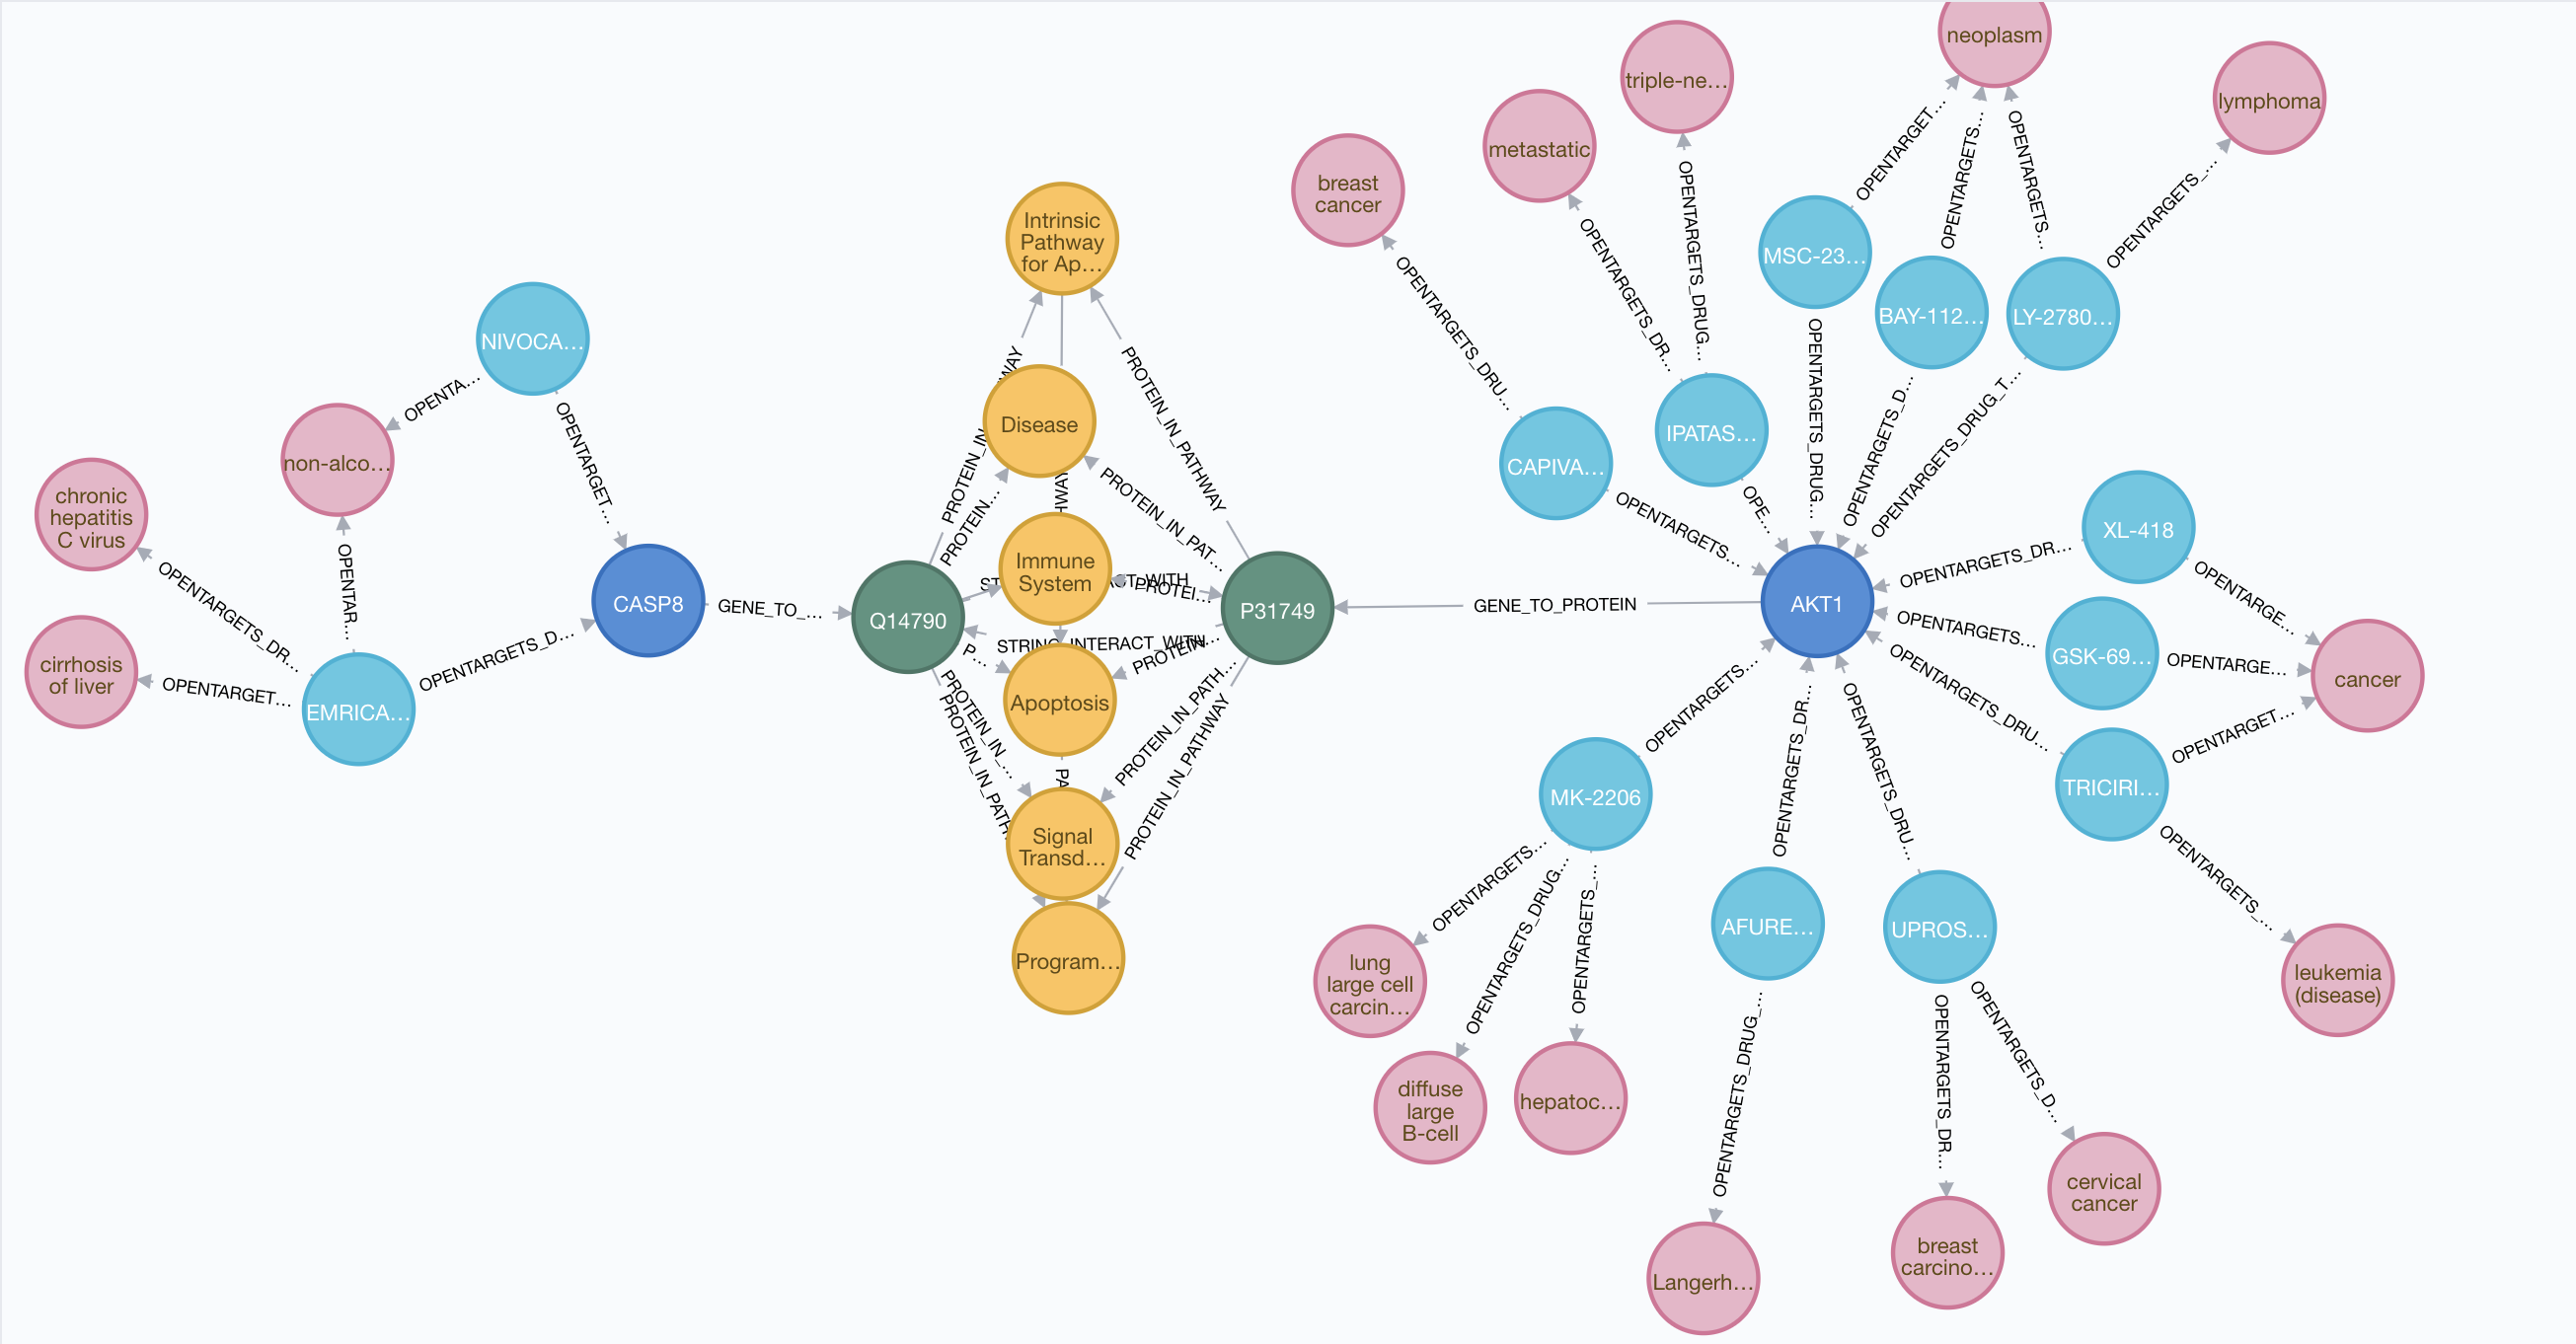

In [59]:
#MATCH (gene1:Gene)-[gene1_to_protein:GENE_TO_PROTEIN]->(protein1:Protein)-[protein1_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) <-[protein2_in_pathway:PROTEIN_IN_PATHWAY]-(protein2:Protein)-[gene2_to_protein:GENE_TO_PROTEIN]-(gene2:Gene)
#WHERE gene1.name in ['CASP8'] AND gene2.name in ['AKT1']
#match (gene2)-[gene2_to_drug]-(drug2:Drug)-[drug2_to_disease]-(d2:Disease)
#match (gene1)-[gene1_to_drug]-(drug1:Drug)-[drug1_to_disease]-(d1:Disease)
#set drug1.name = drug1.label
#set d1.name = d1.label
#set drug2.name = drug2.label
#set d2.name = d2.label
#RETURN gene1,protein1,  pathway, protein2, gene2,
#		gene2_to_drug,  drug2, drug2_to_disease, d2,
#        gene1_to_drug,  drug1, drug1_to_disease, d1
Image(filename = "figures/pathway_CASP8-AKT1.png")

In [58]:
x=merged2_bc[merged2_bc['gene1.name'] == 'GATAD2A']
x[x['gene2.name'] == 'HDAC2']

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,d.label,is_it_breast_cancer
279636,GATAD2A,RNA Polymerase I Promoter Clearance,R-HSA-73854,HDAC2,other,breast cancer,yes
279635,GATAD2A,RNA Polymerase I Promoter Clearance,R-HSA-73854,HDAC2,other,breast adenocarcinoma,yes
144131,GATAD2A,Infectious disease,R-HSA-5663205,HDAC2,disease_pathway,breast cancer,yes
144130,GATAD2A,Infectious disease,R-HSA-5663205,HDAC2,disease_pathway,breast adenocarcinoma,yes
279739,GATAD2A,RNA Polymerase I Transcription,R-HSA-73864,HDAC2,other,breast cancer,yes
281273,GATAD2A,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,R-HSA-427389,HDAC2,other,breast cancer,yes
279738,GATAD2A,RNA Polymerase I Transcription,R-HSA-73864,HDAC2,other,breast adenocarcinoma,yes
281272,GATAD2A,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,R-HSA-427389,HDAC2,other,breast adenocarcinoma,yes
276328,GATAD2A,Chromatin organization,R-HSA-4839726,HDAC2,other,breast adenocarcinoma,yes
276329,GATAD2A,Chromatin organization,R-HSA-4839726,HDAC2,other,breast cancer,yes


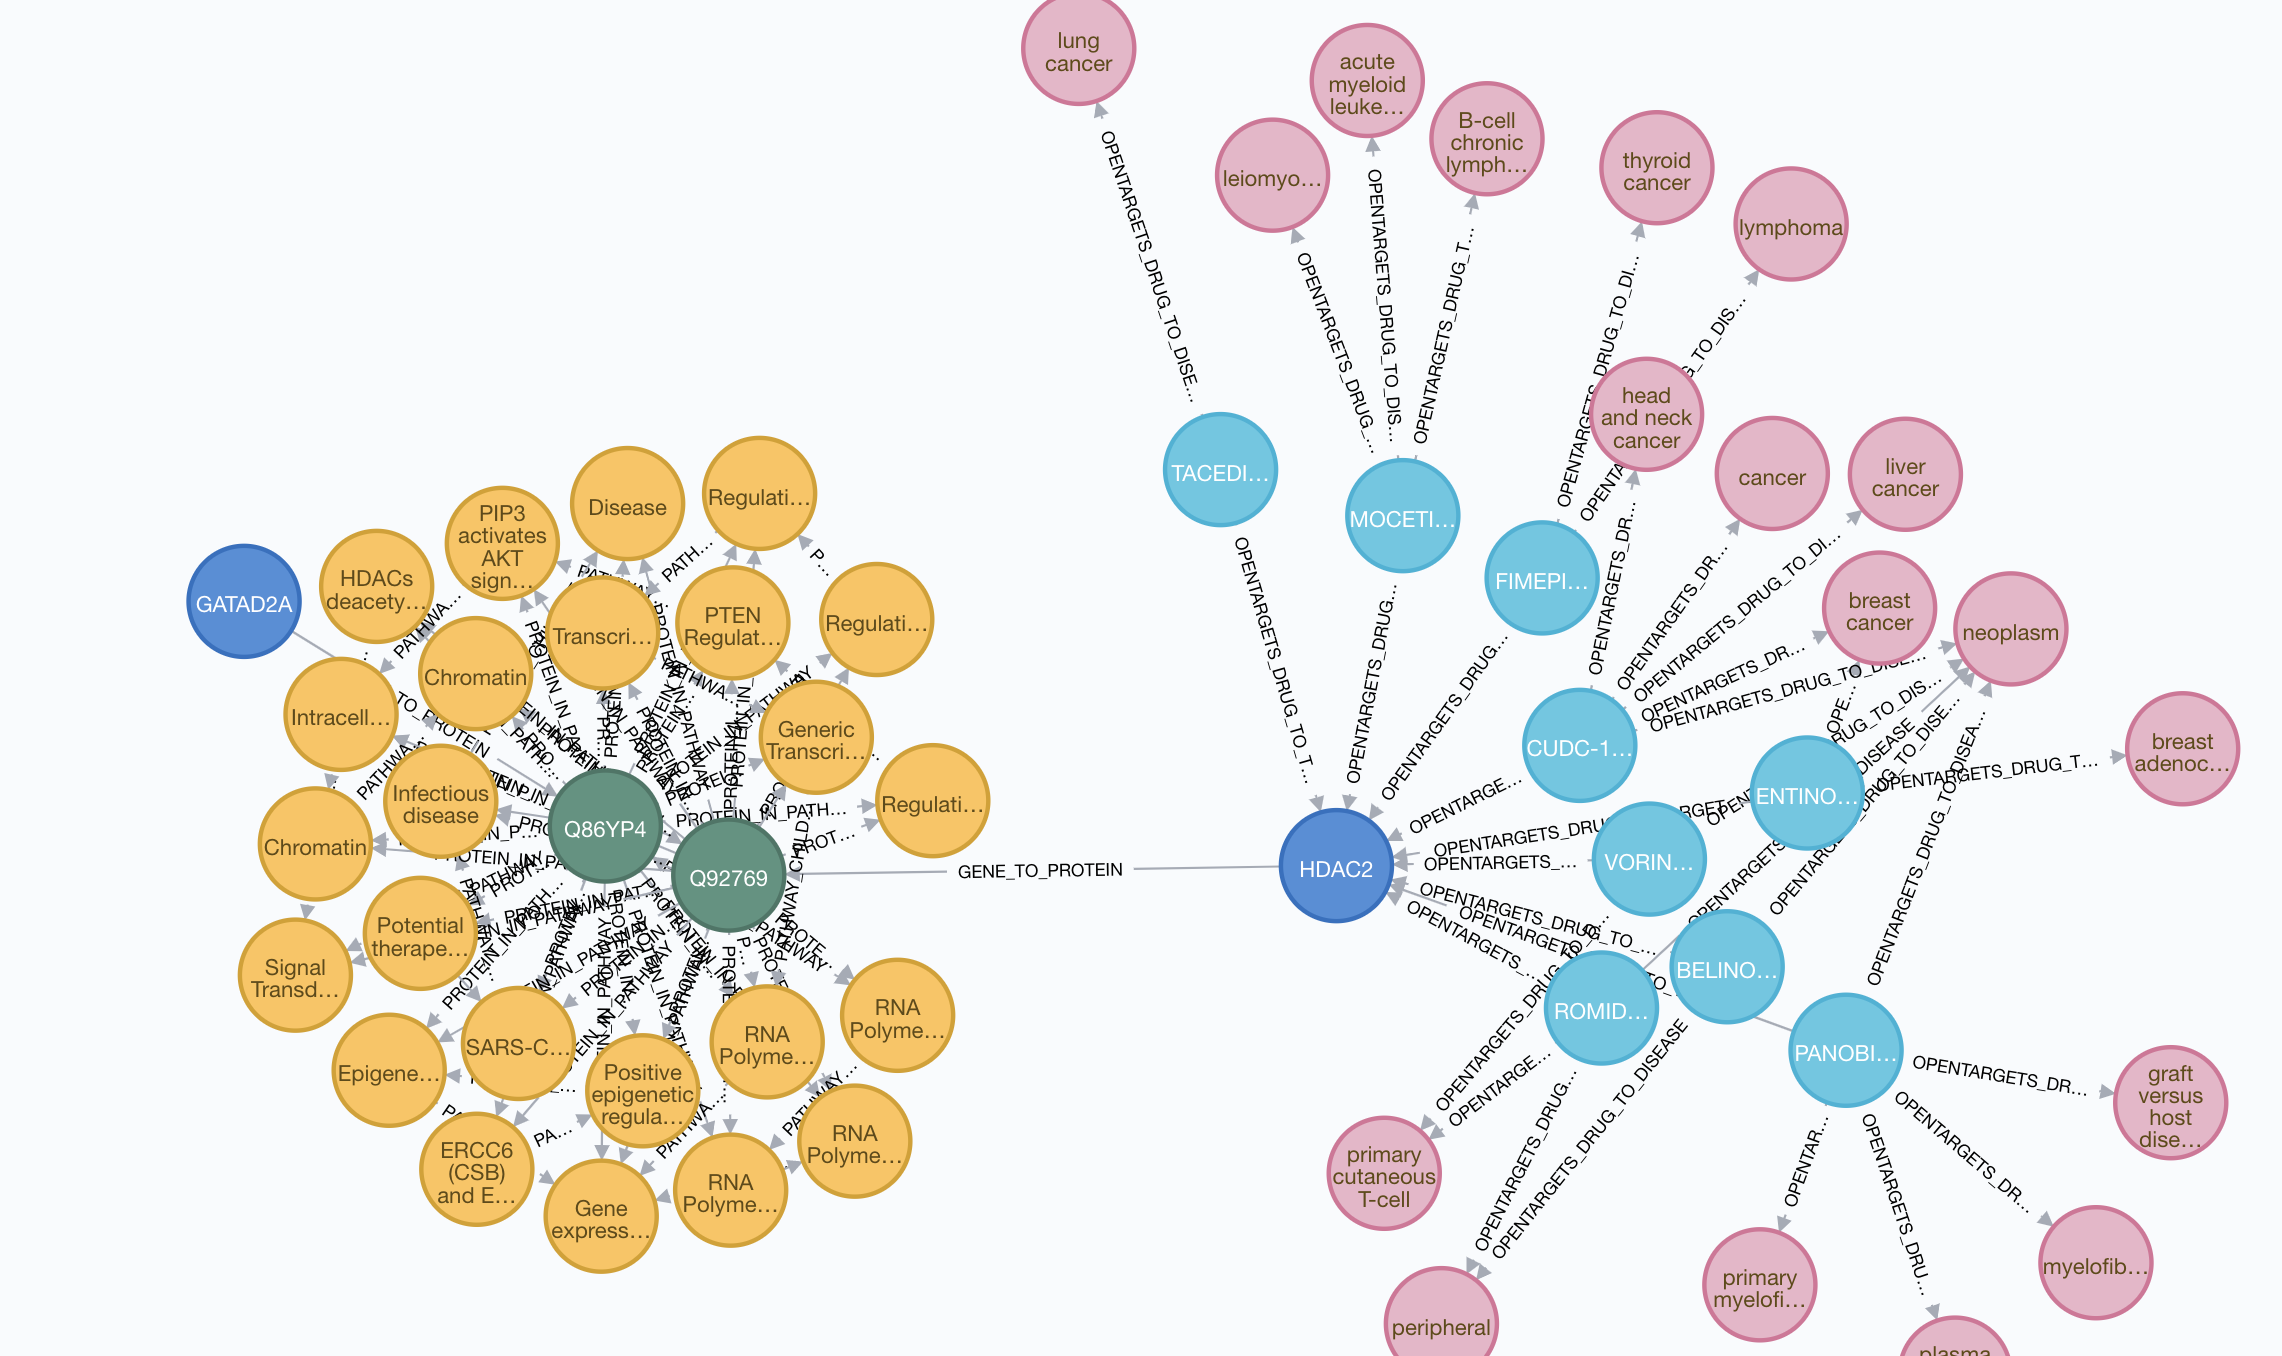

In [60]:
Image(filename = "figures/pathway_GATAD2A_HDAC2.png")
